df read success, column names: Index(['Datum', 'Warengruppe', 'Umsatz', 'KielerWoche', 'Bewoelkung',
       'Temperatur', 'Windgeschwindigkeit', 'Wettercode'],
      dtype='object')


/var/folders/2f/68j5g5gd69v_hdqj03fsfwt00000gn/T/ipykernel_61935/363712013.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['Temperature_Binned', 'Warengruppe'])['Umsatz'].sum().reset_index()


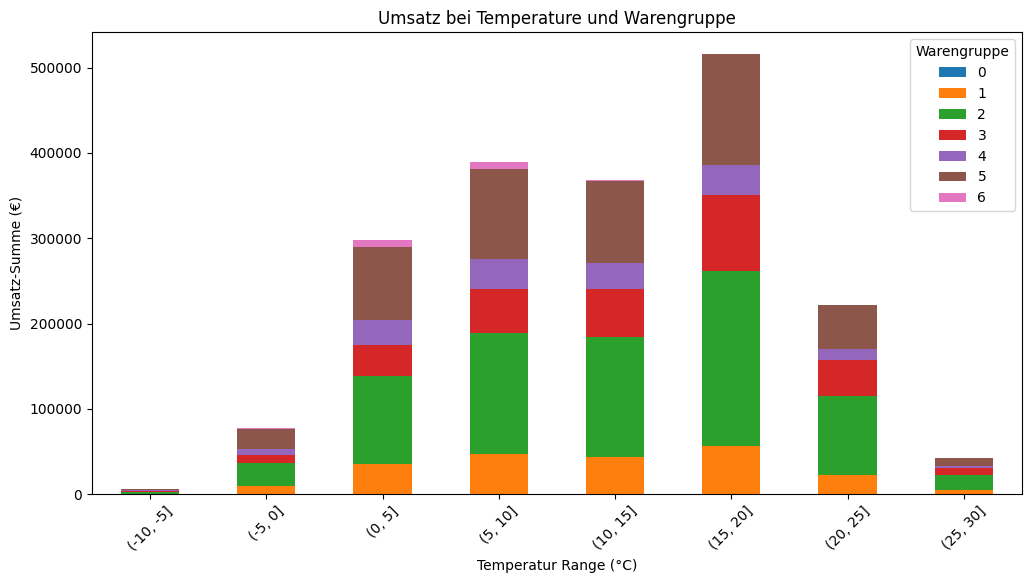

Warengruppe 1:
  Coefficient (slope): 1.27
  Intercept: 106.69
  R-squared: 0.05

Warengruppe 2:
  Coefficient (slope): 11.01
  Intercept: 272.40
  R-squared: 0.32

Warengruppe 3:
  Coefficient (slope): 6.55
  Intercept: 85.73
  R-squared: 0.39

Warengruppe 4:
  Coefficient (slope): -0.57
  Intercept: 94.15
  R-squared: 0.01

Warengruppe 5:
  Coefficient (slope): 2.30
  Intercept: 249.35
  R-squared: 0.03

Warengruppe 6:
  Coefficient (slope): -2.59
  Intercept: 82.45
  R-squared: 0.08



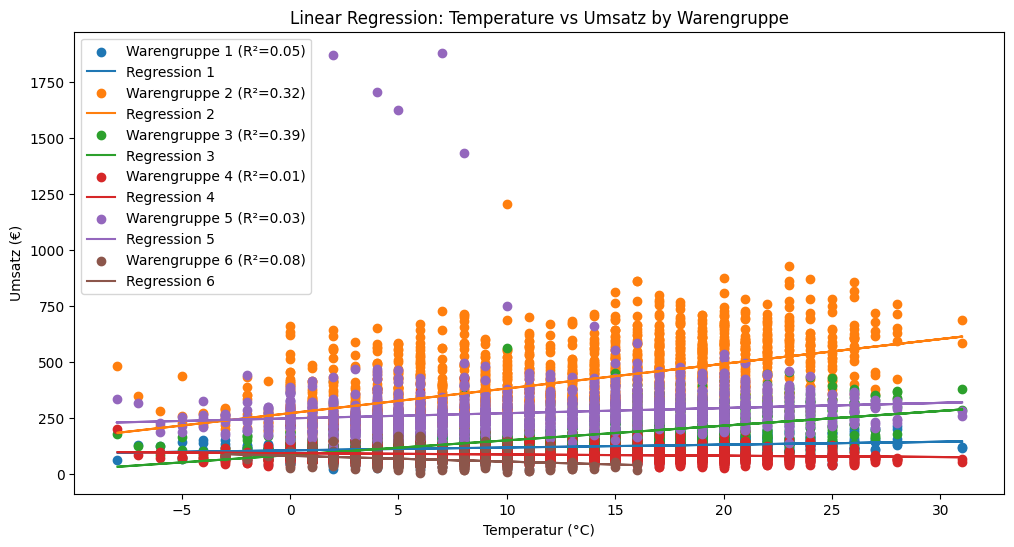

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.options.mode.chained_assignment = None  # default='warn'

# CSV einlesen
df = pd.read_csv('zusammengefuehrte_daten.csv', sep=';')

print('====================================================================')
print('df read success, column names: ' + str(df.columns))
print('====================================================================')

# Datum in Datetime umwandeln
df['DatumParsed'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y')

# ########### WARENGRUPPE ###########

# Null-Werte in Warengruppe ersetzen
df['Warengruppe'] = df['Warengruppe'].fillna("0,0")


# ########### UMSATZ ###########

# Null-Werte in Umsatz ersetzen
df['Umsatz'] = df['Umsatz'].fillna("0,0")

# Zahl-Trennzeichen ändern, float muss einen Punkt haben, vorhanden ist Komma. Werte in Float umwandeln
df['Warengruppe'] = df['Warengruppe'].str.replace(',', '.').astype(float)
# Warengruppe in Integer umwandeln
df['Warengruppe'] = df['Warengruppe'].astype(int)


# ########### TEMPERATUR ###########

# Null-Werte in Temperatur ersetzen
df.dropna(subset=['Temperatur'], inplace=True)
# Zahl-Trennzeichen ändern, float muss einen Punkt haben, vorhanden ist Komma. Werte in Float umwandeln
df['Temperatur'] = df['Temperatur'].str.replace(',', '.').astype(float)
# Temperatur in Integer umwandeln
df['Temperatur'] = df['Temperatur'].astype(int)


# ########### UMSATZ ###########

# Zahl-Trennzeichen ändern, float muss einen Punkt haben, vorhanden ist Komma. Werte in Float umwandeln
df['Umsatz'] = df['Umsatz'].str.replace(',', '.').astype(float)
# Umsatz in Integer umwandeln
df['Umsatz'] = df['Umsatz'].astype(int)


# ########### Stacked Bar-Chart ###########

# Abgrenzung von Daten
data = df[['Umsatz', 'Temperatur', 'Warengruppe']]

# Mindest- und Maximaltemperatur bestimmen, um Bins in 5er Schritten zu erstellen
min_temp = int(data['Temperatur'].min())
max_temp = int(data['Temperatur'].max())
temperature_bins = np.arange(min_temp, max_temp, 5)
data['Temperature_Binned'] = pd.cut(data['Temperatur'], bins=temperature_bins)

# Gruppiere Daten nach Temperatur und Warengruppe und summiere Umsatz
grouped_data = data.groupby(['Temperature_Binned', 'Warengruppe'])['Umsatz'].sum().reset_index()

# Pivotisiere die Daten
pivot_data = grouped_data.pivot(index='Temperature_Binned', columns='Warengruppe', values='Umsatz').fillna(0)

# Erstelle einen Bar-Chart
pivot_data.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Umsatz bei Temperature und Warengruppe')
plt.xlabel('Temperatur Range (°C)')
plt.ylabel('Umsatz-Summe (€)')
plt.legend(title='Warengruppe')
plt.xticks(rotation=45)
plt.show()


# ########### Lineare Regression mit Streudiagram ###########

# Abgrenzung Daten für die Bestimmung einer linearen Regression (Zusammenhang Umsatz und Temperatur je Warengruppe)
linearRegressionDf = df[['Umsatz', 'Temperatur', 'Warengruppe']]
# Bestimme die eindeutigen Warengruppen
warengruppen = linearRegressionDf['Warengruppe'].unique()
# Entferne Warengruppe 0
warengruppen = warengruppen[warengruppen != 0]
# Sortiere die Warengruppen
warengruppen.sort()

# definiere die Größe des Plots
plt.figure(figsize=(12, 6))

# Iteriere druch jede vorhandene Warengruppe
for wg in warengruppen:
    # Filter die aktuelle Warengruppe
    wg_data = linearRegressionDf[linearRegressionDf['Warengruppe'] == wg]
    
    # Extract features and target
    X = wg_data['Temperatur'].values.reshape(-1, 1)  # Temperature as feature
    y = wg_data['Umsatz'].values  # Umsatz as target
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values
    y_pred = model.predict(X)
    
    # Calculate R-squared
    r2 = r2_score(y, y_pred)
    
    # Plot data points
    plt.scatter(X, y, label=f'Warengruppe {wg} (R²={r2:.2f})')
    
    # Plot regression line
    plt.plot(X, y_pred, label=f'Regression {wg}')
    
    # Print regression details
    print(f"Warengruppe {wg}:")
    print(f"  Coefficient (slope): {model.coef_[0]:.2f}")
    print(f"  Intercept: {model.intercept_:.2f}")
    print(f"  R-squared: {r2:.2f}\n")

# Erstelle die Grafik
plt.title('Linear Regression: Temperature vs Umsatz by Warengruppe')
plt.xlabel('Temperatur (°C)')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()
